In [28]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os.path

In [2]:
ticker = "TNA"

In [44]:
def getDB(ticker):
    tick = ticker
    # Load data
    data = yf.Ticker(tick)
    df = data.history(period="5y", interval="1d")
#     df = data.history(start="2018-12-01", end="2020-03-01")
#     start="2017-01-01", end="2017-04-30"
    
    # add data points
    df['close_per1'] = df.ta.percent_return(1)*100
    df['sma10'] = df.ta.sma(length=10)
    df['williams'] = df.ta.willr()


    df = df[[
            'open','close','sma10','williams','close_per1'
            ]]

    df = df.dropna()
    
    return df

In [45]:
data = getDB(ticker)
print(data['close_per1'].std())
print(data.head(5))
print(data.tail(5))

4.4499947493182095
                 open      close      sma10   williams  close_per1
date                                                              
2017-01-23  48.812677  48.649506  49.949430 -85.270667   -1.135450
2017-01-24  49.163742  50.775669  50.048322 -47.116216    4.370370
2017-01-25  52.031586  52.328259  50.155619 -16.129040    3.057743
2017-01-26  52.348029  51.715122  50.177868 -19.549857   -1.171712
2017-01-27  51.764578  51.111897  50.261431 -32.036851   -1.166440
                 open      close      sma10   williams  close_per1
date                                                              
2021-12-23  83.099998  84.199997  78.760229 -26.619072    2.395711
2021-12-27  84.500000  86.599998  79.254777 -14.188268    2.850358
2021-12-28  86.199997  85.029999  79.934092 -22.320079   -1.812933
2021-12-29  84.889999  85.260002  80.845266 -17.004946    0.270497
2021-12-30  85.180000  85.139999  81.375690 -17.658998   -0.140749


In [5]:
def set_data(ticker):
    df = getDB(ticker)

    df['CP_ol'] = 0
    df['CO_il'] = 0
    df['SMA10_il'] = 0
    df['W_il'] = 0
    
    value = df['close_per1'].std()
    
    # setting the outputs in the df
    for i in range(len(df)):
        if df.iloc[i]['close_per1'] > value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 2
        elif df.iloc[i]['close_per1'] < -value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 1
        else:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 0
    
    # setting the inputs in the df
    for i in range(len(df)-1):
        try:
            if df.iloc[i]['close'] < df.iloc[i+1]['open']:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 1
            else:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 0
        except:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        try:
            if df.iloc[i]['close'] > df.iloc[i]['sma10']:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 1
            else:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 0
        except:
            df.iloc[i, df.columns.get_loc('SMA10_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        if df.iloc[i]['williams'] > -30: # overbought
            df.iloc[i, df.columns.get_loc('W_il')] = -1
        elif df.iloc[i]['williams'] < -70: # oversold
            df.iloc[i, df.columns.get_loc('W_il')] = 1
        else:
            df.iloc[i, df.columns.get_loc('W_il')] = 0 # neutral
    
    
    # deleting data that is not normalized
    del df['open']
    del df['close']
    del df['sma10']
    del df['williams']
#     del df['close_per1']
    
    # reformating
    df = df[[
            'W_il','SMA10_il','CO_il','CP_ol','close_per1'
            ]]
    
    return df

In [6]:
df = set_data(ticker)
print(data.head(5))
print(data.tail(5))

                 open      close      sma10   williams  close_per1
date                                                              
2017-01-23  48.812677  48.649506  49.949430 -85.270657   -1.135450
2017-01-24  49.163742  50.775669  50.048321 -47.116180    4.370370
2017-01-25  52.031578  52.328251  50.155617 -16.129058    3.057728
2017-01-26  52.348029  51.715122  50.177867 -19.549730   -1.171697
2017-01-27  51.764578  51.111897  50.261431 -32.036743   -1.166440
                 open      close      sma10   williams  close_per1
date                                                              
2021-12-23  83.099998  84.199997  78.760229 -26.619072    2.395711
2021-12-27  84.500000  86.599998  79.254777 -14.188268    2.850358
2021-12-28  86.199997  85.029999  79.934092 -22.320079   -1.812933
2021-12-29  84.889999  85.260002  80.845266 -17.004946    0.270497
2021-12-30  85.180000  85.139999  81.375690 -17.658998   -0.140749


In [7]:
def process_train(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[0:-SHIFT]
        
        del df['close_per1']
        
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")



In [8]:
def process_test(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        
        del df['close_per1']

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")

In [9]:
SEQ_LEN = 2  # how long of a preceeding sequence to collect for RNN
# FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
SHIFT = 150  # how far to shift the data so it can be back testest
BATCH_SIZE = 64 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
EPOCHS = 500 # how many passes through our data


tickers_train = [ticker]
tickers_test = [ticker]

train_x, train_y = process_train(tickers_train, SEQ_LEN,SHIFT)
validation_x, validation_y = process_test(tickers_test, SEQ_LEN, SHIFT)

In [10]:
print(train_x[0])
print('training data length: %d' % (len(train_x)))
print('validation data length: %d' % (len(validation_x)))

[[-1.  1.  0.]
 [-1.  1.  1.]]
training data length: 315
validation data length: 42


In [11]:
## Building the RNN ##
print()
print("length of train data: ", len(train_x))
print("length of validation data: ", len(validation_x))
print()

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.000015, decay=1e-6)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

print()
print()

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()


length of train data:  315
length of validation data:  42

Epoch 1/500
5/5 [==============================] - 3s 164ms/step - loss: 1.7422 - accuracy: 0.2667 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7181 - accuracy: 0.2603 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6858 - accuracy: 0.2762 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6455 - accuracy: 0.2984 - val_loss: 1.0995 - val_accuracy: 0.3095
Epoch 5/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6360 - accuracy: 0.2762 - val_loss: 1.0995 - val_accuracy: 0.2619
Epoch 6/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6273 - accuracy: 0.2730 - val_loss: 1.0995 - val_accuracy: 0.2857
Epoch 7/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5977 - accuracy: 0.2762 - val_l

5/5 [==============================] - 0s 8ms/step - loss: 1.0188 - accuracy: 0.4698 - val_loss: 1.0844 - val_accuracy: 0.4286
Epoch 60/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0218 - accuracy: 0.4921 - val_loss: 1.0835 - val_accuracy: 0.4524
Epoch 61/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0255 - accuracy: 0.4730 - val_loss: 1.0824 - val_accuracy: 0.4524
Epoch 62/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0206 - accuracy: 0.4825 - val_loss: 1.0814 - val_accuracy: 0.4524
Epoch 63/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0152 - accuracy: 0.4984 - val_loss: 1.0802 - val_accuracy: 0.4524
Epoch 64/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0093 - accuracy: 0.4857 - val_loss: 1.0791 - val_accuracy: 0.4524
Epoch 65/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0114 - accuracy: 0.4635 - val_loss: 1.0780 - val_accuracy: 0.4524
Epoch 66/500
5/5 [===============

5/5 [==============================] - 0s 8ms/step - loss: 0.9222 - accuracy: 0.5778 - val_loss: 0.9505 - val_accuracy: 0.6905
Epoch 118/500
5/5 [==============================] - 0s 9ms/step - loss: 0.9204 - accuracy: 0.5746 - val_loss: 0.9473 - val_accuracy: 0.6905
Epoch 119/500
5/5 [==============================] - 0s 17ms/step - loss: 0.9052 - accuracy: 0.6000 - val_loss: 0.9442 - val_accuracy: 0.6905
Epoch 120/500
5/5 [==============================] - 0s 12ms/step - loss: 0.9112 - accuracy: 0.5810 - val_loss: 0.9408 - val_accuracy: 0.6905
Epoch 121/500
5/5 [==============================] - 0s 11ms/step - loss: 0.9146 - accuracy: 0.5810 - val_loss: 0.9376 - val_accuracy: 0.6905
Epoch 122/500
5/5 [==============================] - 0s 11ms/step - loss: 0.9113 - accuracy: 0.5746 - val_loss: 0.9344 - val_accuracy: 0.6905
Epoch 123/500
5/5 [==============================] - 0s 11ms/step - loss: 0.9084 - accuracy: 0.5905 - val_loss: 0.9313 - val_accuracy: 0.6905
Epoch 124/500
5/5 [===

Epoch 175/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8627 - accuracy: 0.6127 - val_loss: 0.8172 - val_accuracy: 0.6905
Epoch 176/500
5/5 [==============================] - 0s 10ms/step - loss: 0.8609 - accuracy: 0.6159 - val_loss: 0.8158 - val_accuracy: 0.6905
Epoch 177/500
5/5 [==============================] - 0s 11ms/step - loss: 0.8588 - accuracy: 0.6286 - val_loss: 0.8146 - val_accuracy: 0.6905
Epoch 178/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8627 - accuracy: 0.6190 - val_loss: 0.8131 - val_accuracy: 0.6905
Epoch 179/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8658 - accuracy: 0.6127 - val_loss: 0.8119 - val_accuracy: 0.6905
Epoch 180/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8583 - accuracy: 0.6127 - val_loss: 0.8106 - val_accuracy: 0.6905
Epoch 181/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8545 - accuracy: 0.6222 - val_loss: 0.8094 - val_accuracy: 0.6905
Epoch 182/5

Epoch 233/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8184 - accuracy: 0.6444 - val_loss: 0.7650 - val_accuracy: 0.6905
Epoch 234/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8197 - accuracy: 0.6317 - val_loss: 0.7645 - val_accuracy: 0.6905
Epoch 235/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8209 - accuracy: 0.6413 - val_loss: 0.7638 - val_accuracy: 0.6905
Epoch 236/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8158 - accuracy: 0.6444 - val_loss: 0.7634 - val_accuracy: 0.6905
Epoch 237/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8200 - accuracy: 0.6413 - val_loss: 0.7627 - val_accuracy: 0.6905
Epoch 238/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8184 - accuracy: 0.6476 - val_loss: 0.7623 - val_accuracy: 0.6905
Epoch 239/500
5/5 [==============================] - 0s 9ms/step - loss: 0.8197 - accuracy: 0.6444 - val_loss: 0.7619 - val_accuracy: 0.6905
Epoch 240/500

Epoch 291/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7862 - accuracy: 0.6413 - val_loss: 0.7364 - val_accuracy: 0.6905
Epoch 292/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7808 - accuracy: 0.6667 - val_loss: 0.7357 - val_accuracy: 0.6905
Epoch 293/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7860 - accuracy: 0.6476 - val_loss: 0.7354 - val_accuracy: 0.6905
Epoch 294/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7881 - accuracy: 0.6222 - val_loss: 0.7353 - val_accuracy: 0.6905
Epoch 295/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7840 - accuracy: 0.6508 - val_loss: 0.7351 - val_accuracy: 0.6905
Epoch 296/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7846 - accuracy: 0.6603 - val_loss: 0.7351 - val_accuracy: 0.6905
Epoch 297/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7808 - accuracy: 0.6571 - val_loss: 0.7346 - val_accuracy: 0.6905
Epoch 298/50

Epoch 349/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7552 - accuracy: 0.6540 - val_loss: 0.7161 - val_accuracy: 0.6905
Epoch 350/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7576 - accuracy: 0.6381 - val_loss: 0.7154 - val_accuracy: 0.6905
Epoch 351/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7584 - accuracy: 0.6667 - val_loss: 0.7149 - val_accuracy: 0.6905
Epoch 352/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7571 - accuracy: 0.6667 - val_loss: 0.7147 - val_accuracy: 0.6905
Epoch 353/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7603 - accuracy: 0.6603 - val_loss: 0.7146 - val_accuracy: 0.6905
Epoch 354/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7618 - accuracy: 0.6603 - val_loss: 0.7143 - val_accuracy: 0.6905
Epoch 355/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7680 - accuracy: 0.6444 - val_loss: 0.7142 - val_accuracy: 0.6905
Epoch 35

Epoch 407/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7291 - accuracy: 0.6635 - val_loss: 0.7012 - val_accuracy: 0.6905
Epoch 408/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7377 - accuracy: 0.6603 - val_loss: 0.7010 - val_accuracy: 0.6905
Epoch 409/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7352 - accuracy: 0.6540 - val_loss: 0.7008 - val_accuracy: 0.6905
Epoch 410/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7350 - accuracy: 0.6571 - val_loss: 0.7007 - val_accuracy: 0.6905
Epoch 411/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7402 - accuracy: 0.6667 - val_loss: 0.7007 - val_accuracy: 0.6905
Epoch 412/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7270 - accuracy: 0.6508 - val_loss: 0.7001 - val_accuracy: 0.6905
Epoch 413/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7308 - accuracy: 0.6635 - val_loss: 0.6998 - val_accuracy: 0.6905
Epoch 414/500

Epoch 465/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7127 - accuracy: 0.6603 - val_loss: 0.6884 - val_accuracy: 0.6905
Epoch 466/500
5/5 [==============================] - 0s 9ms/step - loss: 0.7150 - accuracy: 0.6444 - val_loss: 0.6880 - val_accuracy: 0.6905
Epoch 467/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7135 - accuracy: 0.6540 - val_loss: 0.6877 - val_accuracy: 0.6905
Epoch 468/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7288 - accuracy: 0.6476 - val_loss: 0.6876 - val_accuracy: 0.6905
Epoch 469/500
5/5 [==============================] - 0s 12ms/step - loss: 0.7207 - accuracy: 0.6698 - val_loss: 0.6874 - val_accuracy: 0.6905
Epoch 470/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7145 - accuracy: 0.6603 - val_loss: 0.6872 - val_accuracy: 0.6905
Epoch 471/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7207 - accuracy: 0.6476 - val_loss: 0.6877 - val_accuracy: 0.6905
Epoch 4

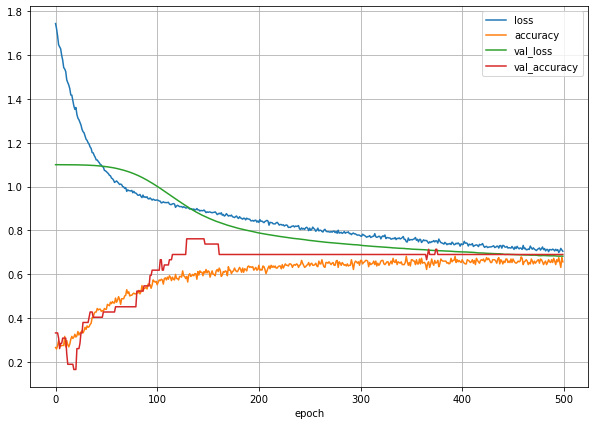

Test loss: 0.6825287938117981
Test accuracy: 0.6904761791229248


In [12]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('epoch')
plt.grid()
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [47]:
def process_test_buys(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        print(df.tail(15))

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!
        
        Sequential_data = Sequential_data + sequential_data
        
    X = []; y = []; z = []
    for seq, target, actual in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        z.append(actual)

    return np.array(X).astype("float64"), np.array(y).astype("uint8"), np.array(z).astype("float64")

In [48]:
last_trading_days = 20
test_x, test_y, test_z = process_test_buys(tickers_test, SEQ_LEN, last_trading_days)

            W_il  SMA10_il  CO_il  CP_ol  close_per1
date                                                
2021-12-09     1         0      0      1   -6.827178
2021-12-10     1         0      1      0   -0.873471
2021-12-13     1         0      0      0   -4.185535
2021-12-14     1         0      0      0   -2.669567
2021-12-15     0         0      0      2    4.842527
2021-12-16     1         0      1      1   -6.221058
2021-12-17     1         0      0      0    2.682863
2021-12-20     1         0      0      0   -4.263614
2021-12-21     0         1      1      2    8.627715
2021-12-22     0         1      0      0    2.851790
2021-12-23    -1         1      1      0    2.395711
2021-12-27    -1         1      1      0    2.850358
2021-12-28    -1         1      0      0   -1.812933
2021-12-29    -1         1      0      0    0.270497
2021-12-30    -1         1      0      0   -0.140749


In [49]:
print(test_x[-1])
print(test_y[-1])
print(test_z[-1])

[[-1.  1.  0.]
 [-1.  1.  0.]]
0
-0.14074917144651922


In [16]:
output = model.predict(test_x)

In [17]:
results = []; total = 0
for i, j in zip(output, test_z):
    if np.argmax(i) == 2:
        total += 1
#         results.append([i,j])
        results.append(j)

In [34]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Trading period: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
print('Average daily return: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Trading period: 5 percent, over 8 trades.
Average daily return: 5 percent, over 8 trades.
You started with $5000 and finished with $7591 after 8 trades.


In [19]:
print(results)

[1.4082912116520685, -0.772769021589037, 5.025056559514063, 5.726489588815231, 2.945719141125891, 8.35394753164409, -1.2505481437498966, 2.017374950722206, -2.9965008400013704, 0.6445998637189643, 4.458672335756675, 5.388521343106012, 4.3221755332707, -0.5709564715190796, 4.776841940851462, 1.0774372730292692, 4.736963722489929, 1.7171922475946566, 4.332835651170441, -0.9142991318043636, 1.9584132644258512, -2.2327137641667827, 6.005465774391272, 0.657241209325643, 4.243112701059504, 0.9386188953442121, 2.4476563509958416, 0.23331953432994545, -1.2771784113766782, -1.2791909238900834, -0.6247845791248041, -6.820156418592194, 6.840351822165136, -0.8734705143035981, 8.627715496969547, 2.3957114324287376, 2.850358210053372]


In [20]:
results = []; total = 0
for i, j in zip(output, test_z):
    if i[2] > 0.6:
        total += 1
#         results.append([i,j])
        results.append(j)

In [21]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Trading period: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
print('Average daily return: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period: 5 percent, over 8 trades.
Average daily return: 5 percent, over 8 trades.
You started with $5000 and finished with $7591 after 8 trades.


In [22]:
print(results)

[5.025056559514063, 2.945719141125891, 4.458672335756675, 4.736963722489929, 4.332835651170441, 6.005465774391272, 6.840351822165136, 8.627715496969547]


In [29]:

if os.path.isfile('TNA_model.h5') is False:
    model.save('TNA_model.h5')

In [30]:
model1 = load_model('TNA_model.h5')

In [31]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 2, 32)             4608      
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 32)             128       
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                24832     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 34,179
Trainable params: 33,987
Non-trainable params: 192
________________________________________________

In [58]:
output = model1.predict(test_x[-2:-1])
print(np.argmax(output))

0


In [56]:
print(test_x[-2:-1])

[[[-1.  1.  0.]
  [-1.  1.  0.]]]
